In [79]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images
import tensorflow as tf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import json
import skimage.draw

In [5]:
import galaxia

In [6]:
%matplotlib inline 

### Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Folders


In [8]:
ROOT_DIR

'/home/ubuntu/lab/mask_r_cnn/Mask_RCNN'

In [9]:
GALAXIA_DIR = os.path.join(ROOT_DIR, "samples/zoo1/dataset")
GALAXIA_DIR

'/home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/dataset'

In [10]:
# FPath to save records and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "samples/zoo1/modelos")
MODEL_DIR

'/home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/modelos'

In [11]:
# Path to the weights of the network
WEIGHTS_PATH = os.path.join(MODEL_DIR,"galaxia_heads.h5")
WEIGHTS_PATH

'/home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/modelos/galaxia_heads.h5'

### Detection configuration

In [12]:
config = galaxia.GalaxiaConfig()

In [14]:

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.9


config = InferenceConfig()
#config.display()

### Read model

In [16]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",config=config,model_dir=MODEL_DIR)

In [17]:
# Read the weights of the trained network
print("Loading weights ", WEIGHTS_PATH)
model.load_weights(WEIGHTS_PATH, by_name=True)

Loading weights  /home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/modelos/galaxia_heads.h5


###  Validation Dataset


In [18]:
%%time
# Validation dataset
dataset_val = galaxia.GalaxiaDataset()
dataset_val.load_galaxia(GALAXIA_DIR, "val")
dataset_val.prepare()

CPU times: user 2.82 s, sys: 204 ms, total: 3.02 s
Wall time: 6.47 s


6


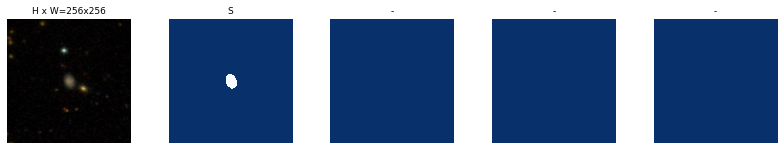

1568


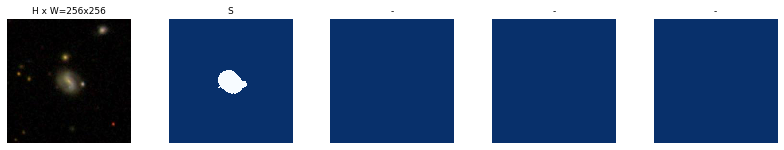

In [19]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 2)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

### Run Detection

In [42]:
import datetime

In [44]:
image_id = 1957
image = dataset_val.load_image(image_id)

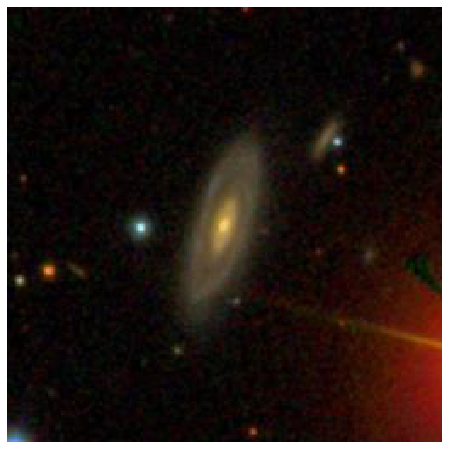

In [45]:
#image
plt.figure(figsize = (8,8))
plt.imshow(image)
plt.axis('off')
plt.show()

image ID: galaxia.Dr7_588297863634878786.jpg (1957) /home/ubuntu/lab/mask_r_cnn/Mask_RCNN/samples/zoo1/dataset/val/Dr7_588297863634878786.jpg
(256, 256, 3)
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -19.04000  max:  244.29000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
elapsed time for detection: 0.38474s
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   73.00000  max:  187.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


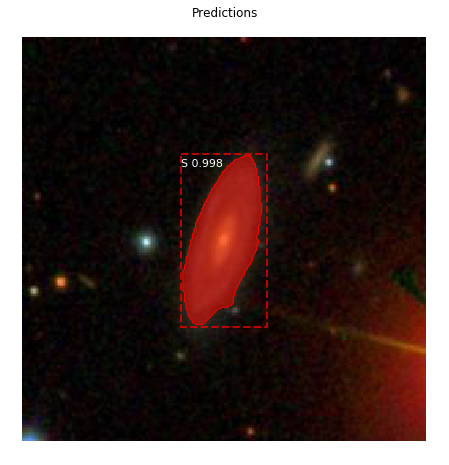

In [46]:
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))

print (image.shape)
start = datetime.datetime.now()
results = model.detect([image], verbose=1)
stop = datetime.datetime.now()


ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("elapsed time for detection: {}s".format((stop-start).total_seconds()))
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Step by Step Prediction

### Stage 1: Region Proposal Network

### 1.a RPN Targets



In [47]:

target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (16368,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -0.22097  max:    1.15371  float64
positive_anchors         shape: (1, 4)                min:   82.74517  max:  173.25483  float64
negative_anchors         shape: (255, 4)              min:  -22.62742  max:  259.31371  float64
neutral anchors          shape: (16112, 4)            min:  -90.50967  max:  282.50967  float64
refined_anchors          shape: (1, 4)                min:   73.00000  max:  187.00000  float32


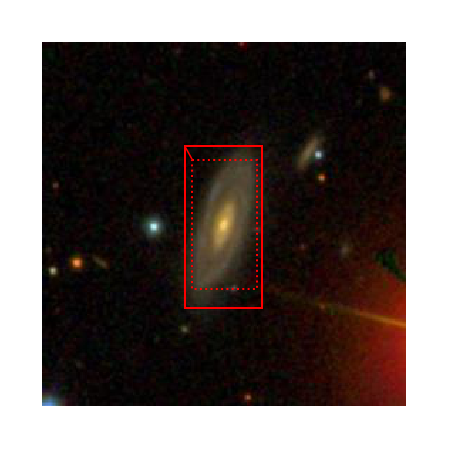

In [48]:

visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions
Here we run the RPN graph and display its predictions.

In [49]:
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: 
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 16368, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35494  max:    1.10396  float32
refined_anchors          shape: (1, 6000, 4)          min:   -1.67782  max:    2.67523  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (2000,)               min:    0.00000  max: 2009.00000  int32
proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


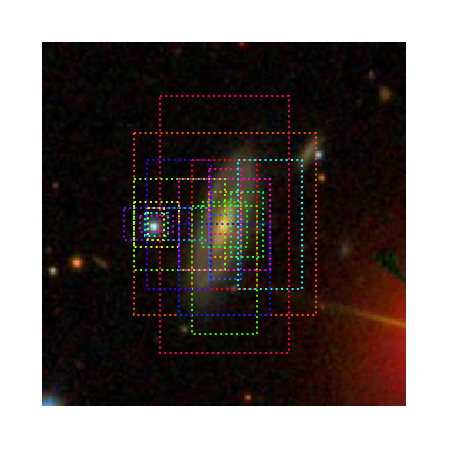

In [51]:
# Show top anchors by score (before refinement)
limit = 20
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

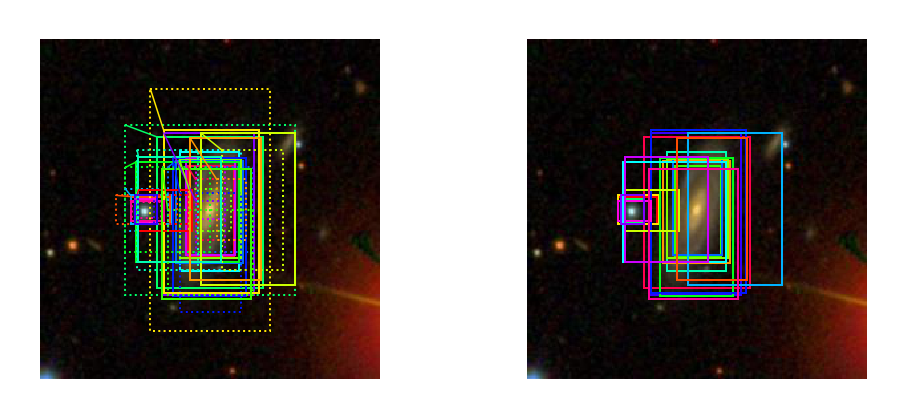

In [53]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 20
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

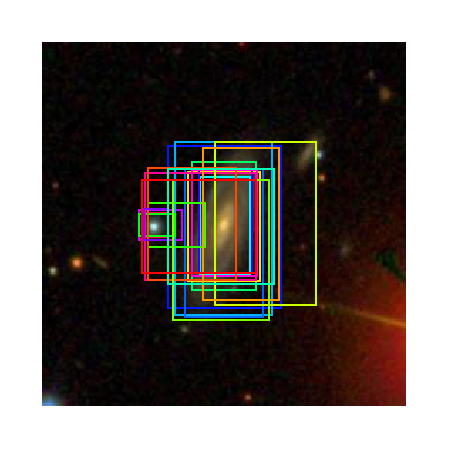

In [55]:
# Show refined anchors after non-max suppression
limit = 20
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

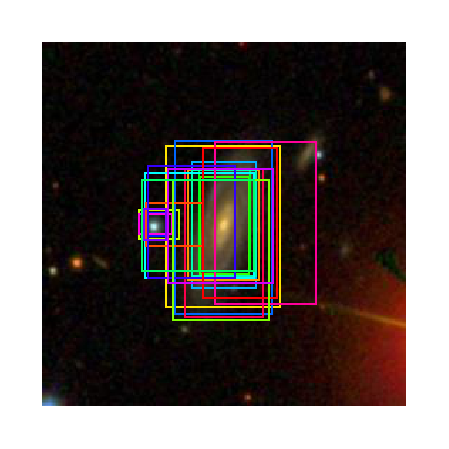

In [56]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 20
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification
This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification
Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [57]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 2000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 2000, 3, 4)       min:   -5.21874  max:    3.86162  float32
masks                    shape: (1, 400, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 400, 6)           min:    0.00000  max:    1.00000  float32


1 detections: ['S']


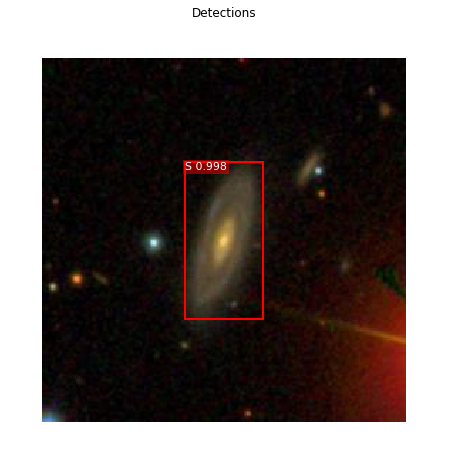

In [60]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_val.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection
Here we dive deeper into the process of processing the detections.

In [62]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_val.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

2000 Valid proposals out of 2000
34 Positive ROIs
[('BG', 1966), ('S', 34)]


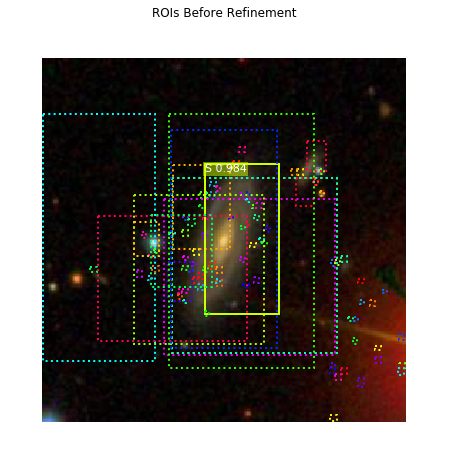

In [67]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 100
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

### Apply Bounding Box Refinement

roi_bbox_specific        shape: (2000, 4)             min:   -5.21874  max:    3.86162  float32
refined_proposals        shape: (2000, 4)             min:  -14.00000  max:  292.00000  int32


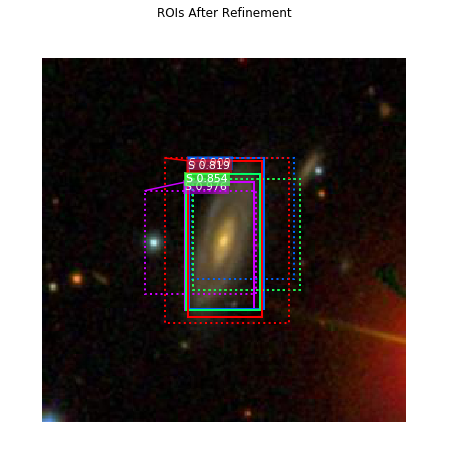

In [68]:

# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

### Filter Low Confidence Detections

In [69]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 34 detections:
[   0    1    2    4    5    6    8    9   11   16   17   18   19   22
   26   28   29   31   54   70   75   96  154  175  211  315  423  639
  791  860  939 1078 1096 1697]


In [70]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 18:
[   0    1    2    4    5    6    8    9   11   16   17   18   19   26
   28   75  211 1096]


### Per-Class Non-Max Suppression

In [72]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_val.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

S                     : [   0    1    2    4    5    6    8    9   11   16   17   18   19   26
   28   75  211 1096] -> [1]

Kept after per-class NMS: 1
[1]


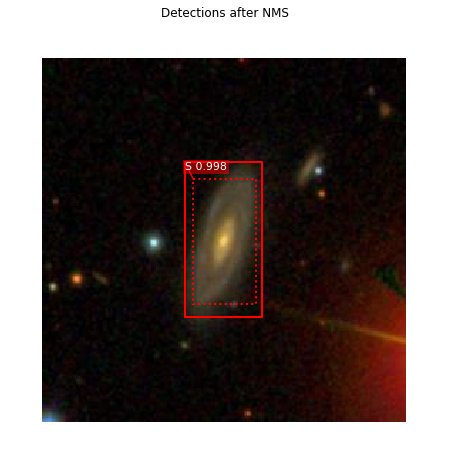

In [74]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks
This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets
These are the training targets for the mask branch

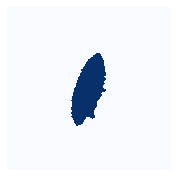

In [77]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [90]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

detections               shape: (1, 400, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 400, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
1 detections: ['S']


In [91]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (1, 28, 28)           min:    0.00001  max:    1.00000  float32
det_masks                shape: (1, 256, 256)         min:    0.00000  max:    1.00000  bool


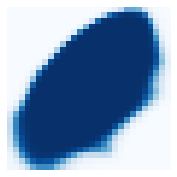

In [92]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

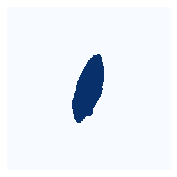

In [93]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

### Visualize Activations
In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [80]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 256, 256, 3)      min:  -19.04000  max:  244.28999  float32
res2c_out                shape: (1, 64, 64, 256)      min:    0.00000  max:   20.49473  float32
res3c_out                shape: (1, 32, 32, 512)      min:    0.00000  max:   27.86533  float32
res4w_out                shape: (1, 16, 16, 1024)     min:    0.00000  max:   53.61581  float32
rpn_bbox                 shape: (1, 16368, 4)         min:   -9.04289  max:   30.45750  float32
roi                      shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


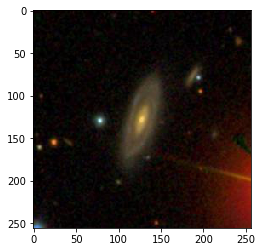

In [81]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

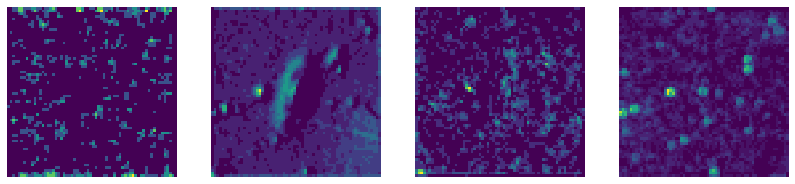

In [84]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

### Visualize Activations
In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

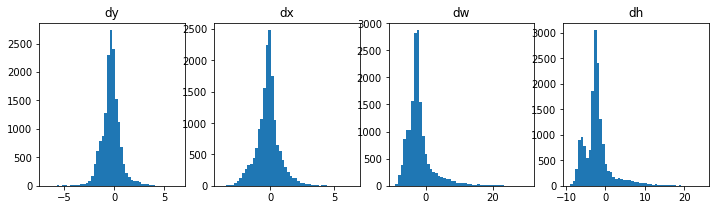

In [87]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

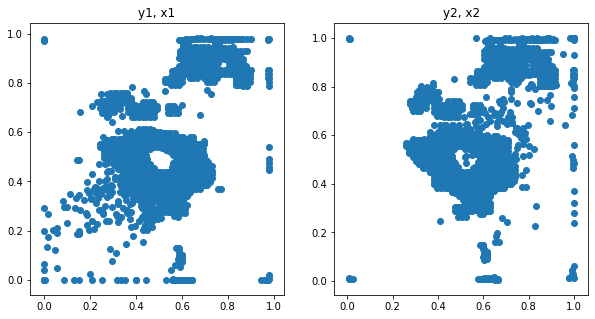

In [88]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()